<a href="https://www.kaggle.com/code/muhammadnadhifn/lmsys-chatbot-preference-predictions-dnn?scriptVersionId=203018137" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Task: Classify between two given prompt on two model
<br><br>
Deep Neural Network Solution
1. Bidirectional LSTM -> extract feature of prompt and respond/answer
2. Attention Mechanism -> captures the relevance or correlation between the prompt and each response
3. Global Pooling -> reduces the sequence of attention-weighted features while retaining the most significant information, enabling the dense layers to make a final classification.
4. Dense/Hidden Layers -> perform the classification

In [1]:
import keras
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
from matplotlib import pyplot as plt

2024-10-24 07:50:45.835971: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered

2024-10-24 07:50:45.836083: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered

2024-10-24 07:50:45.970807: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load Train Data
df = pd.read_csv('/kaggle/input/lmsys-chatbot-arena/train.csv')

# Download Stopwords
# nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Define Function to Remove Stopwords
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Parse String and Ensure all text data is encoded to UTF-8
for col in [i for i in df.columns if i in ['prompt', 'response_a', 'response_b']]:
    df[col] = df[col].map(lambda x: eval(x.replace("null", "''"))[0])
    df[col] = df[col].apply(lambda x: str(x).encode('utf-8', errors='ignore').decode('utf-8'))
    # Lower Text
    df[col] = df[col].str.lower()
    # Remove Punctuation
    df[col] = df[col].str.replace(r'[^\w\s]', '', regex=True)
    # Remove Stopwords
    df[col] = df[col].apply(remove_stopwords)

# Show Sample
df.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,morally right try certain percentage females m...,question whether morally right aim certain per...,ai dont personal beliefs opinions however tell...,1,0,0
1,53567,koala-13b,gpt-4-0613,difference marriage license marriage certificate,marriage license legal document allows couple ...,marriage license marriage certificate two diff...,0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,explain function calling would call function,function calling process invoking executing fu...,function calling process invoking function pro...,0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,create test set rare category want build class...,creating test set rare category challenging ma...,building classifier rare category creating tes...,1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,best way travel telaviv jerusalem car bus plane,best way travel tel aviv jerusalem depends per...,best way travel telaviv jerusalem depends pers...,0,1,0


In [3]:
# Create label dictionary for mapping
label_map = {'winner_model_a': 0, 'winner_model_b': 1, 'winner_tie': 2}

# Map column into label
df['label'] = df[['winner_model_a', 'winner_model_b', 'winner_tie']].idxmax(axis=1).map(label_map)

In [4]:
# Tokenizer
tokenizer = Tokenizer()
texts = df['prompt'].tolist() + df['response_a'].tolist() + df['response_b'].tolist()
tokenizer.fit_on_texts(texts)

In [5]:
def preprocess_fn(prompt, response_a, response_b, label=None):
    prompt = pad_sequences(tokenizer.texts_to_sequences(prompt), maxlen=512, padding='post', truncating='post')
    response_a = pad_sequences(tokenizer.texts_to_sequences(response_a), maxlen=512, padding='post', truncating='post')
    response_b = pad_sequences(tokenizer.texts_to_sequences(response_b), maxlen=512, padding='post', truncating='post')
    feature = {
        'prompt': prompt,
        'response_a': response_a,
        'response_b': response_b
    }
    return (feature, label) if label is not None else feature

def build_dataset(prompt, response_a, response_b, label=None, batch_size=1, shuffle=True):
    slices = (preprocess_fn(prompt, response_a, response_b, label))
    ds = tf.data.Dataset.from_tensor_slices(slices)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(prompt))
    ds = ds.batch(batch_size=batch_size)
    return ds

In [6]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df.label)

train_ds = build_dataset(
    prompt=train_df.prompt.values.tolist(),
    response_a=train_df.response_a.values.tolist(),
    response_b=train_df.response_b.values.tolist(),
    label=train_df.label.values.tolist(),
    batch_size=32,
    shuffle=True
)

val_ds = build_dataset(
    prompt=val_df.prompt.values.tolist(),
    response_a=val_df.response_a.values.tolist(),
    response_b=val_df.response_b.values.tolist(),
    label=val_df.label.values.tolist(),
    batch_size=32,
    shuffle=False
)

In [7]:
# Inspect the dataset
for feature, label in train_ds:
    print(f"Feature 1: {feature['prompt'].numpy().shape}, Feature 2: {feature['response_a'].numpy().shape}, Feature 3: {feature['response_b'].numpy().shape}, Label: {label.numpy().shape}")
    break

Feature 1: (32, 512), Feature 2: (32, 512), Feature 3: (32, 512), Label: (32,)


In [8]:
# Define input layers with integer-encoded sequences
prompt_input = tf.keras.Input(shape=(512,), name='prompt')
response_a_input = tf.keras.Input(shape=(512,), name='response_a')
response_b_input = tf.keras.Input(shape=(512,), name='response_b')

# Reshape inputs to (batch_size, sequence_length, 1) for LSTM
prompt_reshaped = layers.Reshape((512, 1))(prompt_input)
response_a_reshaped = layers.Reshape((512, 1))(response_a_input)
response_b_reshaped = layers.Reshape((512, 1))(response_b_input)

# Define LSTM layer
bi_lstm = layers.Bidirectional(layers.LSTM(100, return_sequences=True))

# Apply LSTM to reshaped inputs
prompt_encoded = bi_lstm(prompt_reshaped)
response_a_encoded = bi_lstm(response_a_reshaped)
response_b_encoded = bi_lstm(response_b_reshaped)

attention_a = layers.Attention()([prompt_encoded, response_a_encoded])
attention_b = layers.Attention()([prompt_encoded, response_b_encoded])

pool_a = layers.GlobalAveragePooling1D()(attention_a)
pool_b = layers.GlobalAveragePooling1D()(attention_b)

# Concatenate encoded outputs
x = layers.Concatenate()([pool_a, pool_b])
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(8, activation='relu')(x)

# Output layer
outputs = layers.Dense(3, activation='softmax')(x)

# Build and compile the model
model = tf.keras.Model(inputs=[prompt_input, response_a_input, response_b_input], outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ prompt (InputLayer) │ (None, 512)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ response_a          │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ response_b          │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 512, 1)    │          0 │ prompt[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 512, 1)    │          0 │ response_a[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 512, 1)    │          0 │ response_b[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 512, 200)  │     81,600 │ reshape[0][0],    │
│ (Bidirectional)     │                   │            │ reshape_1[0][0],  │
│                     │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 512, 200)  │          0 │ bidirectional[0]… │
│ (Attention)         │                   │            │ bidirectional[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 512, 200)  │          0 │ bidirectional[0]… │
│ (Attention)         │                   │            │ bidirectional[2]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 200)       │          0 │ attention[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 200)       │          0 │ attention_1[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 400)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    102,656 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     16,448 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8)         │        520 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3)         │         27 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 201,251 (786.14 KB)

 Trainable params: 201,251 (786.14 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
tf.keras.backend.clear_session()

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(train_ds, validation_data=val_ds, epochs=128, callbacks=[early_stopping])

Epoch 1/128

1437/1437 ━━━━━━━━━━━━━━━━━━━━ 263s 180ms/step - accuracy: 0.3983 - loss: 1.0750 - val_accuracy: 0.4338 - val_loss: 1.0632

Epoch 2/128

1437/1437 ━━━━━━━━━━━━━━━━━━━━ 258s 180ms/step - accuracy: 0.4391 - loss: 1.0597 - val_accuracy: 0.4368 - val_loss: 1.0633

Epoch 3/128

1437/1437 ━━━━━━━━━━━━━━━━━━━━ 258s 179ms/step - accuracy: 0.4396 - loss: 1.0573 - val_accuracy: 0.4332 - val_loss: 1.0629

Epoch 4/128

1437/1437 ━━━━━━━━━━━━━━━━━━━━ 258s 179ms/step - accuracy: 0.4409 - loss: 1.0569 - val_accuracy: 0.4422 - val_loss: 1.0591

Epoch 5/128

1437/1437 ━━━━━━━━━━━━━━━━━━━━ 258s 179ms/step - accuracy: 0.4402 - loss: 1.0584 - val_accuracy: 0.4420 - val_loss: 1.0581

Epoch 6/128

1437/1437 ━━━━━━━━━━━━━━━━━━━━ 258s 179ms/step - accuracy: 0.4397 - loss: 1.0572 - val_accuracy: 0.4442 - val_loss: 1.0589

Epoch 7/128

1437/1437 ━━━━━━━━━━━━━━━━━━━━ 258s 179ms/step - accuracy: 0.4382 - loss: 1.0564 - val_accuracy: 0.4462 - val_loss: 1.0572

Epoch 8/128

1437/1437 ━━━━━━━━━━━━━━━━━━

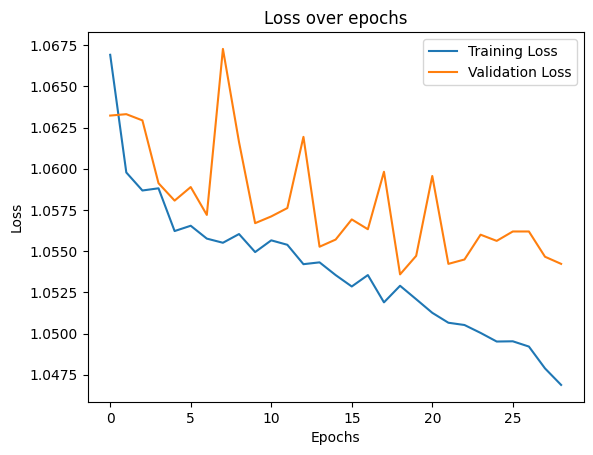

In [10]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
# Load Test Data
test_df = pd.read_csv('/kaggle/input/lmsys-chatbot-arena/test.csv')

# Parse String and Ensure all text data is encoded to UTF-8
for col in [i for i in df.columns if i in ['prompt', 'response_a', 'response_b']]:
    test_df[col] = test_df[col].map(lambda x: eval(x.replace("null", "''"))[0])
    test_df[col] = test_df[col].apply(lambda x: str(x).encode('utf-8', errors='ignore').decode('utf-8'))
    # Lower Text
    test_df[col] = test_df[col].str.lower()
    # Remove Punctuation
    test_df[col] = test_df[col].str.replace(r'[^\w\s]', '', regex=True)
    # Remove Stopwords
    test_df[col] = test_df[col].apply(remove_stopwords)

# Show Sample
test_df.head()

,id,prompt,response_a,response_b
0,136060,three oranges today ate orange yesterday many ...,two oranges today,still three oranges eating orange yesterday af...
1,211333,mediator heated political debate two opposing ...,thank sharing details situation mediator under...,mr reddy ms blue valid points arguments one ha...
2,1233961,initialize classification head transfer learni...,want initialize classification head transfer l...,initialize classification head performing tran...


In [12]:
test_ds = build_dataset(
    prompt=test_df.prompt.values.tolist(),
    response_a=test_df.response_a.values.tolist(),
    response_b=test_df.response_b.values.tolist(),
    batch_size=32,
    shuffle=False
)

In [13]:
test_pred = model.predict(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step


In [14]:
submission_df = test_df[["id"]].copy()
submission_df[['winner_model_a', 'winner_model_b', 'winner_tie']] = test_pred.tolist()
submission_df.to_csv("submission.csv", index=False)
submission_df.head()

,id,winner_model_a,winner_model_b,winner_tie
0,136060,0.250793,0.319200,0.430008
1,211333,0.451664,0.266332,0.282004
2,1233961,0.282704,0.426792,0.290503
